In [38]:
import numpy as np
import pandas as pd
import jsonlines
from collections import defaultdict, Counter

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

In [32]:
lang2name = {
    'en': 'ENG',
    'ar': 'ARB',
    'be': 'BEL',
    'bg': 'BUL',
    'da': 'DAN',
    'et': 'EST',
    'de': 'DEU',
    'el': 'ELL',
    'fr': 'FRA',
    'id': 'IND',
    'ja': 'JPN',
    'ko': 'KOR',
    'zh': 'CMN',
    'pt': 'POR',
    'ru': 'RUS',
    'es': 'SPA',
    'sw': 'SWA',
    'ta': 'TAM',
    'tr': 'TUR',
    'vi': 'VIE',
}

In [2]:
train_base = "/science/image/nlp-datasets/emanuele/data/wit/annotations/"
test_base = "/science/image/nlp-datasets/emanuele/data/wit/annotations/"

In [3]:
langs = ['ar', 'bg', 'da', 'el', 'en', 'et', 'id', 'ja', 'ko', 'tr', 'vi']

print("lang", "#img", "#cap")
for lang in langs:

    df = pd.read_csv(test_base + f"test_{lang}.tsv", sep='\t')

    with jsonlines.open(test_base + f"test_{lang}.jsonl") as reader:
        caps = [e for e in reader]

    for cap in caps:
        assert cap['image_url'] in df['image_url'].values

    print(lang, len(df), len(caps))

lang #img #cap
ar 793 891
bg 806 860
da 814 891
el 541 570
en 685 1000
et 780 874
id 854 901
ja 842 1000
ko 889 931
tr 681 721
vi 869 946


In [4]:
for cap in caps:
    assert cap['image_url'] in df['image_url'].values

## Distribution of captions per image

In [33]:
lang2vals = {}
for lang in langs:

    with jsonlines.open(test_base + f"test_{lang}.jsonl") as reader:
        caps = [e for e in reader]
        
    img_count = defaultdict(int)

    for cap in caps:
        img_count[cap['image_url']] += 1
        
    lang2vals[lang] = list(img_count.values())

    print(lang, np.mean(list(img_count.values())), np.max(list(img_count.values())))

ar 1.1235813366960907 11
bg 1.066997518610422 6
da 1.0945945945945945 6
el 1.0536044362292052 14
en 1.4598540145985401 20
et 1.1205128205128205 11
id 1.0550351288056206 6
ja 1.187648456057007 24
ko 1.047244094488189 3
tr 1.0587371512481645 4
vi 1.0886075949367089 6


ar 0.9117276166456494
bg 0.9491315136476427
da 0.9299754299754299
el 0.9722735674676525
en 0.7094890510948905
et 0.9358974358974359
id 0.9590163934426229
ja 0.9085510688836105
ko 0.9583802024746907
tr 0.9559471365638766
vi 0.9367088607594937


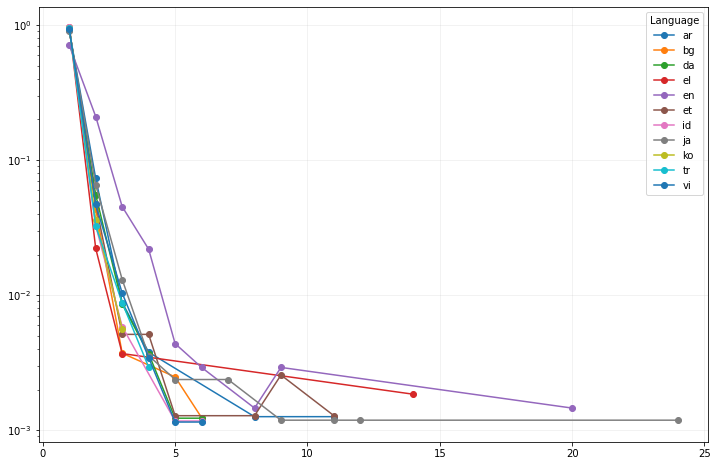

In [72]:
f, ax = plt.subplots(figsize=(12,8))
width=0.1
n_langs = len(langs)
for ix, lang in enumerate(langs):
    cnt = Counter(lang2vals[lang])
    xs = list(cnt.keys())
    ixs = np.argsort(xs)
    xs = np.array(xs)[ixs]
    ys = [v/len(lang2vals[lang]) for v in cnt.values()]
    ys = np.array(ys)[ixs]
    print(lang, ys[0])
    ax.plot(xs, ys, '-o', label=lang)
ax.legend(title="Language")
ax.set_yscale("log")
ax.grid(alpha=0.2)

## Overlaps

In [5]:
langs = ['en', 'ar', 'bg', 'da', 'el', 'et', 'id', 'ja', 'ko', 'tr', 'vi']

In [6]:
lang2urls = {l: set() for l in langs}
for lang in langs:
    with jsonlines.open(test_base + f"test_{lang}.jsonl") as reader:
        caps = [e for e in reader]
    for cap in caps:
        lang2urls[lang].add(cap['image_url'])
        
mat = np.zeros((len(lang2urls), len(lang2urls)), dtype=float)

for ix1, l1 in enumerate(langs):
    for ix2, l2 in enumerate(langs):
        if ix1 != ix2:
            mat[ix1, ix2] = len(lang2urls[l1].intersection(lang2urls[l2]))
        else:
            mat[ix1, ix2] = np.nan

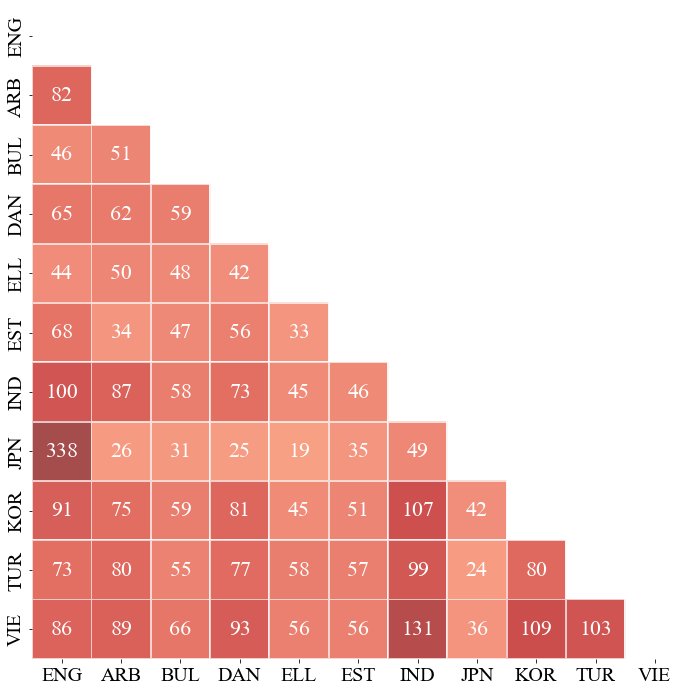

In [69]:
import seaborn as sns

f, ax = plt.subplots(figsize=(12,12))

mask = np.zeros_like(mat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.color_palette("OrRd", as_cmap=True)

annot = [[np.nan for _ in range(len(langs))] for _ in range(len(langs))]
for (i, j), z in np.ndenumerate(mat):
    if i != j:
        annot[i][j] = int(mat[i][j])
sns_plot = sns.heatmap(mat, mask=mask, cmap=cmap, alpha=0.7, vmin=0, vmax=150, center=0, annot=annot, fmt=".0f",
                       square=True, linewidths=1, cbar=False, annot_kws={'fontsize': 22, 'color': 'w'}) #, cbar_kws={"shrink": .5})

ax.set_xticklabels([lang2name[lang] for lang in langs], fontsize=20)
ax.set_yticklabels([lang2name[lang] for lang in langs], fontsize=20)

f.savefig("wit-overlaps.pdf", bbox_inches="tight")

## Captions length distribution

In [72]:
lang2test = {}
for lang in langs:
    with jsonlines.open(test_base + f"test_{lang}.jsonl") as reader:
        lang2test[lang] = [item for item in reader]
lang2test_lens = {lang: [len(e['caption_reference_description']) for e in l] for lang, l in lang2test.items()}

en 690
ar 533
bg 771
da 537
el 404
et 588
id 628
ja 368
ko 168
tr 408
vi 476


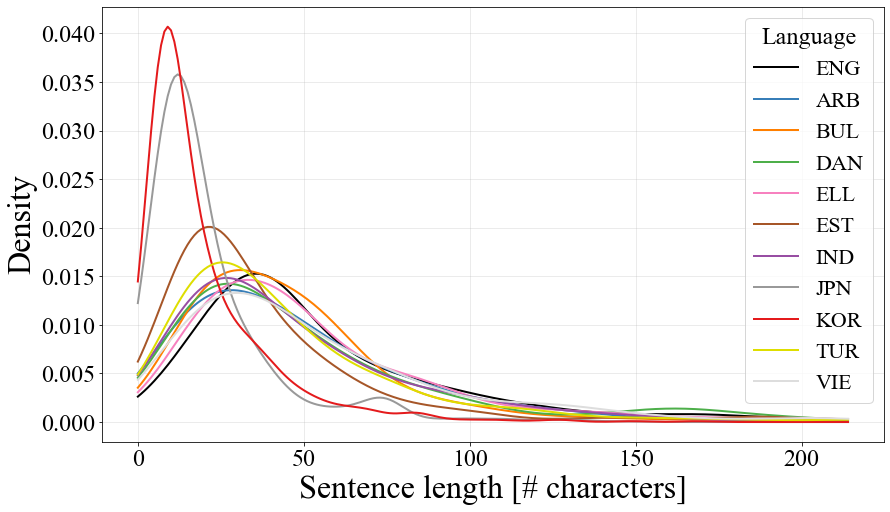

In [80]:
from scipy import stats

f, ax = plt.subplots(1, 1, figsize=(14,8))

colors = ['#000000', '#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00', '#dddddd']

x = np.arange(0, 215, 1)
for ix, (lang, l) in enumerate(lang2test_lens.items()):
    print(lang, max(l))
    density = stats.kde.gaussian_kde(l)
    ax.plot(x, density(x), lw=2, label=lang2name[lang], color=colors[ix])
    
ax.grid(alpha=0.3)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xlabel('Sentence length [# characters]', fontsize=32)
ax.set_ylabel('Density', fontsize=32)
ax.legend(title='Language', loc='upper right', ncol=1, fontsize=22, title_fontsize=24)

f.savefig("wit-lens.pdf", bbox_anchor="tight")

## Leakage

In [78]:
train_urls = set()

with jsonlines.open(train_base + f"train_en.jsonl") as reader:
    caps = [e for e in reader]
for cap in caps:
    train_urls.add(cap['image_url'])

len(caps), len(train_urls)

(500000, 469983)

In [79]:
# URL-based leakage
for l2 in langs:
    print('train',l2, len(train_urls.intersection(lang2urls[l2])))

train ar 0
train bg 0
train da 0
train el 0
train en 0
train et 0
train id 0
train ja 0
train ko 0
train tr 0
train vi 0


In [92]:
# base64-based leakage
train_imgs = set(df['base64_image'].values)
for l2 in langs:
    print('train',l2, len(train_imgs.intersection(lang2imgs[l2])))

train ar 1
train bg 2
train da 0
train el 0
train en 1
train et 0
train id 3
train ja 1
train ko 2
train tr 2
train vi 3
